# Example of DOPER - Generator Assets

### This examples demonstrates the DOPER framework for genset assets with about 150 kW building base load and 100 kW Photovoltaic (PV) generation.

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

### Import DOPER modules

In [2]:
from doper import DOPER, get_solver, get_root, standard_report
from doper.models.basemodel import base_model
from doper.models.battery import add_battery
from doper.models.genset import add_genset
from doper.example import (default_parameter, ts_inputs, 
                           parameter_add_genset, parameter_add_battery,
                           ts_inputs_variable_co2)
from doper.plotting import plot_dynamic

### Setup Optimization Model

In [3]:
from pyomo.environ import Objective, minimize

def control_model(inputs, parameter):
    model = base_model(inputs, parameter)
    model = add_genset(model, inputs, parameter)
    model = add_battery(model, inputs, parameter)
    
    # model objective is defined to include only total CO2 emissions
    def objective_function(model):
        return model.co2_total
    model.objective = Objective(rule=objective_function, sense=minimize, doc='objective function')
    return model

### Load Example Parameter

In [4]:
parameter = default_parameter()
parameter = parameter_add_genset(parameter)
parameter = parameter_add_battery(parameter)

### Load Example Data

#### Modify Grid CO2 Intensity to be time-variable

In [5]:
data1 = ts_inputs_variable_co2(parameter, scaling=[1,3,2,1])
data2 = ts_inputs_variable_co2(parameter, scaling=[3.1,1.1,2.1,1.1])

#### plot CO2 intensity by scenario

<AxesSubplot:title={'center':'Grid CO2 Intensity by Scenario'}>

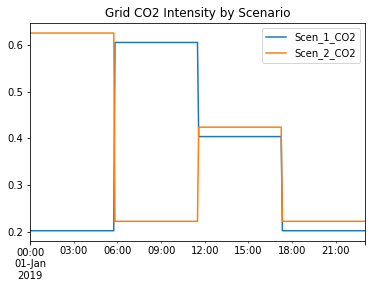

In [6]:
plotData = data1.copy(deep=True)
plotData['Scen_1_CO2'] = data1.grid_co2_intensity
plotData['Scen_2_CO2'] = data2.grid_co2_intensity


plotData[['Scen_1_CO2', 'Scen_2_CO2']].plot(title = 'Grid CO2 Intensity by Scenario')

### Conduct Optimization

In order to conduct the optimization, the DOPER object is initialized with the model, parameter, and the pyomo_to_pandas converter function. In the next step, the model is evaluated with the "do_optimization" class function. It takes the current inputs as input and returns a list of results.

Note that DOPER is built for application as Model Predictive Control (MPC) where the optimization model is periodically, e.g. every five minutes, updated with the most recent inputs, and reevaluated. However, in this example, do_optimization is only executed once.

In [7]:
# Define the path to the solver executable
solver_path = get_solver('cbc', solver_dir=os.path.join(get_root(), 'solvers'))
print(solver_path)
# Initialize DOPER
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_path=solver_path)

# Conduct optimization for CO2 scenarios 1 & 2
res1 = smartDER.do_optimization(data1)
res2 = smartDER.do_optimization(data2)

print('CO2 scenario 1:')
print(standard_report(res1))

print('CO2 scenario 2:')
print(standard_report(res2))

/usr/local/lib/python3.8/dist-packages/doper/solvers/Linux64/cbc


KeyError: 'external_gen'

In [ ]:
# Extract and plot results for scenario 1
duration, objective, df, model, result, termination, parameter = res1

plotData = plot_dynamic(df, parameter, plotFile = None, plot_reg=False)

In [ ]:
# Extract and plot results for scenario 2
duration, objective, df, model, result, termination, parameter = res2

plotData = plot_dynamic(df, parameter, plotFile = None, plot_reg=False)